## Model parameters optimisation

__running time__: < 50 min

The Hi-C data used in these notebooks comes from the manuscript <a name="ref-1"/>[(Stadhouders R, Vidal E, Serra F, Di Stefano B et al. 2018)](#cite-ralph) where Hi-C experiment where conducted in different states during highly-efficient somatic cell reprogramming of somatic cells into pluripotent stem cells (PSCs) by the transcription factors (TFs) OCT4, SOX2, KLF4 and MYC.

We are going to generate three-dimensional (3D) models at 10kbp of the region chr3:33950000-35450000 which contains the SOX2 locus in the first (B cells) and last stage (PSC cells) of the reprogramming.

The input data for the modelling will be normalized and filtered Hi-C matrix. We already normalized the data in previous notebooks:

In [9]:
%%bash

tadbit describe -w ../results/PSC_rep1/ -t 8 -W Resolution,10000

,-------------------.
| NORMALIZE_OUTPUTs |
,----.-------.-------.-----------.------------.------------.--------------------.---------------------.------------------.------------.---------------.--------.
| Id | JOBid | Input | N_columns | N_filtered | BAM_filter | Cis_percentage_Raw | Cis_percentage_Norm | Slope_700kb_10Mb | Resolution | Normalization | Factor |
|----+-------+-------+-----------+------------+------------+--------------------+---------------------+------------------+------------+---------------+--------|
|  4 |    16 |    23 |    15,975 |        348 |        879 |         102.157286 |               100.0 |        -1.163238 |     10,000 |       Vanilla |      1 |
'----^-------^-------^-----------^------------^------------^--------------------^---------------------^------------------^------------^---------------^--------'


In [8]:
%%bash

tadbit normalize -w ../results/PSC_rep1 -r 10000

  - Parsing BAM (101 chunks)                                                   [2022-11-16 10:09:57]
      -> cis interactions are defined as being bellow 1 Mb
      -> trans interactions are defined as being bellow 5 Mb
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101

  - Collecting cis and total interactions per bin (101 chunks)                 [2022-11-16 10:10:03]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .
  - Removing columns with too few or too much interactions                     [2022-11-16 10:10:04]
      -> too few interactions defined as less than        40 interactions
      -> removed 348 columns of 15975 (2.2%)
  - Rescaling sum of interactions per bins                                     [2022-11-16 10:1

To plot the input matrix we use `tadbit bin`. To pass to tadbit which normalization we want to use for the matrix we pass the `jobid` of the normalization job. In our cas we are going to use the Vanilla normalization:

In [10]:
%%bash

tadbit bin -w ../results/PSC_rep1/ --only_plot \
    -c chr3:33950000-35450000 --resolution 10000  \
    --cmap Reds --format png \
    --norm norm \
    --jobid 16 \
    --triangular


Extraction of chr3:33950000-35450000
Getting norm matrices                                                          [2022-11-16 10:11:16]

  (Matrix size 150x150)                                                        [2022-11-16 10:11:16]

  - Parsing BAM (75 chunks)                                                    [2022-11-16 10:11:16]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

  - Getting matrices                                                           [2022-11-16 10:11:16]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

 - Plotting: norm                                                              [2022-11-16 10:11:17]
Cleaning                                                                       [2022-11-16 10:11:17]
Saving to DB                                                        

Vanilla normalized matrix 10kb

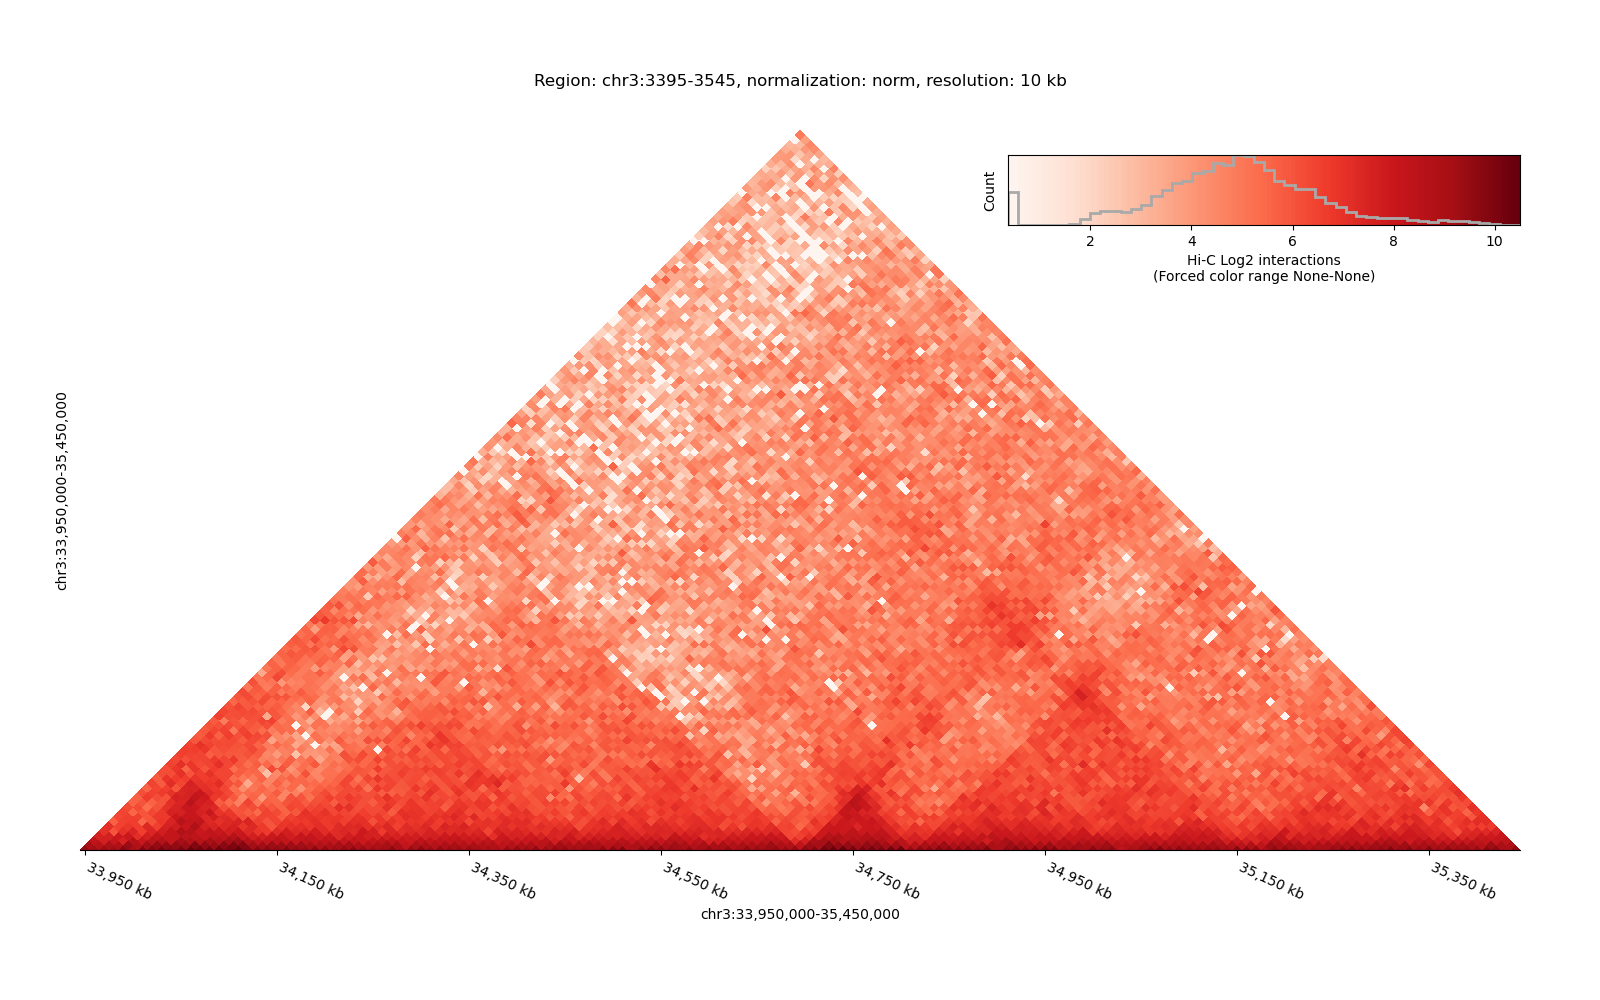

In [11]:
from IPython.display import Image
Image(filename='../results/PSC_rep1/05_sub-matrices/nrm_chr3:3395-3545_10kb_b47e22c268_tri.png') 

Now we create the Hi-C normalized matrix in text format with `tadbit bin` and the `--only_txt` flag

In [12]:
%%bash

tadbit bin -w ../results/PSC_rep1/ --only_txt \
    -c chr3:33950000-35450000 --resolution 10000  \
    --norm norm \
    --jobid 16


Extraction of chr3:33950000-35450000
Getting and writing matrices                                                   [2022-11-16 10:12:13]

  (Matrix size 150x150)                                                        [2022-11-16 10:12:13]

  - Parsing BAM (75 chunks)                                                    [2022-11-16 10:12:13]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

  - Writing matrices                                                           [2022-11-16 10:12:13]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

Cleaning                                                                       [2022-11-16 10:12:14]
Saving to DB                                                                   [2022-11-16 10:12:14]
,------.
| JOBs |
,----.--------------------------------------------

In [13]:
%%bash

head ../results/PSC_rep1/05_sub-matrices/nrm_chr3:3395-3545_10kb_9cc09aece7.abc

# CRM chr3	159745316
# chr3:3395-3545 resolution:10000
# MASKED 
0	52		35.92399852435043
0	2		327.02290938567666
0	24		55.903572101319895
0	30		69.39231116826463
0	71		19.898484328112637
0	1		561.631952088835
0	3		191.77819421133987


### Data Transformation and scoring function

This  step is automatically done in TADbit. 
A a weight is generated for each pair of interactions proportional to their interaction count as in formula:
        
$$weight(I, J) = \frac{\sum^N_{i=0}{\sum^N_{j=0}{(matrix(i, j))}}}{\sum^N_{i=0}{(matrix(i, J))} \times \sum^N_{j=0}{(matrix(I, j))}}$$

The raw data are then multiplied by this weight. In the case that multiple experiments are used, the weighted interaction values are normalised using a factor  (default set as 1) in order to compare between experiments. 
Then, a Z-score of the off-diagonal normalised/weighted interaction is calculated as in formula:

$$zscore(I, J) = \frac{log_{10}(weight(I, J) \times matrix(I, J)) - mean(log_{10}(weight \times matrix))}{stddev(log_{10}(weight \times matrix))}$$

The Z-scores are then transformed to distance restraints. To define the type of restraints  between  each  pair  of  particles. we need to identified  empirically  three  optimal  parameters  (i) a maximal  distance  between  two  non-interacting  particles (maxdist), (ii) a lower-bound  cutoff  to  define  particles  that  do  not  interact  frequently (lowfreq) and (iii) an  upper-bound  cutoff  to  define  particles  that  do  interact  frequently (upfreq). In TADbit this is done via a grid  search  approach.


The following picture shows the different component of the scoring funtion that is optimised during the Monte Carlo  simulated annealing sampling protocol.
Two  consecutive particles are spatially restrained  by  a  harmonic  oscillator  with  an  equilibrium  distance  that  corresponds to  the sum of their radii. Non-consecutive  particles  with  contact  frequencies  above  the  upper-bound  cutoff are restrained by a harmonic  oscillator  at  an  equilibrium  distance,  while  those  below  the  lower-bound  cutoff are maintained further than  an  equilibrium  distance  by  a  lower  bound  harmonic  oscillator.   

![](images/tadbit_restraints.png)


### Optimization of parameters

We need to identified empirically (via a grid-search optimisation) the optimal parameters for the mdoelling procedure:

 - maxdist: maximal distance assosiated two interacting particles.
 - upfreq: to define particles that do interact frequently (defines attraction)
 - lowfreq: to define particles that do not interact frequently ( defines repulsion)
 - dcutoff: the definition of "contact" in units of bead diameter. Value of 2 means that a contact will occur when 2 
    beads are closer than 2 times their diameter. This will be used to compare 3D models with Hi-C interaction maps.
 
 
Pairs of beads interacting less than lowfreq (left dashed line) are penalized if they are closer than their assigned minimum distance (Harmonic lower bound). 
Pairs of beads interacting more than ufreq (right dashed line) are penalized if they are further apart than their assigned maximum distance (Harmonic upper bound).
Pairs of beads which interaction fall in between lowfreq and upfreq are not penalized except if they are neighbours (Harmonic)


![](images/tadbit_distance_freq_fitting.png)


In the parameter optimization step we are going to give a set of ranges for the different search parameters. For each possible combination TADbit will produce a set of models. 

In each individual model we consider that two beads are in contact if their distance in 3D space is lower than the specified distance cutoff. TADbit builds a cumulative contact map for each set of models as shown in the schema below. The contact map is then compared with the Hi-C interaction experiment by means of a Spearman correlation coefficient. The sets having higher correlation coefficients are those that best represents the original data.

![](images/Contact_map.png)

The optimization is conducted by the `tadbit model` with the `--optimize` flag. To pass to tadbit which matrix we want to use we pass the `jobid` of the previously generated text matrix. The following optimization takes around 20 minutes with 8 cpus:

In [14]:
%%bash

tadbit model -w ../results/PSC_rep1/ \
    --reso 10000 \
    --crm chr3 \
    --beg 33950000 --end 35450000 \
    --maxdist 250:250:100 \
    --upfreq=0.4:0.8:0.2 \
    --lowfreq=-1.0:-0.6:0.2 \
    --dcutoff 2:4:1 \
    --scale 0.01 \
    --nmodels 200 --nkeep 100 \
    --cpu 8 \
    --jobid 18 \
    --optimize

     o Loading Hi-C matrix

        Optimization
        ***********

          - Region: Chromosome chr3 from 33950000 to 35450000 at resolution 10 kb (150 particles)

     o Optimizing parameters

Optimizing parameters...


#  Optimization UpFreq LowFreq MaxDist  scale  cutoff | Correlation

       1/3         0.4      -1     250   0.01     2.0 | 0.8193
       2/3         0.4      -1     250   0.01     3.0 | 0.7872
       3/3         0.4      -1     250   0.01     4.0 | 0.6241
       1/3         0.4    -0.8     250   0.01     2.0 | 0.8182
       2/3         0.4    -0.8     250   0.01     3.0 | 0.7843
       3/3         0.4    -0.8     250   0.01     4.0 | 0.6269
       1/3         0.4    -0.6     250   0.01     2.0 | 0.8201
       2/3         0.4    -0.6     250   0.01     3.0 | 0.7876
       3/3         0.4    -0.6     250   0.01     4.0 | 0.6269
       1/3         0.6      -1     250   0.01     2.0 | 0.8096
       2/3         0.6      -1     250   0.01     3.0 | 0.7955
       3/3  

Results are stored in the `07_model/<id>` subfolder. They include the generated ensemble of models of the grid in a format that can be loaded in the python TADbit library and the correlation grid search plot.

In [15]:
%%bash

tadbit describe -w ../results/PSC_rep1/ -t 13

,-----------------.
| MODELED_REGIONs |
,----.-------.-------.--------.------------.--------.-------.-------.
| Id | JOBid |  Type | PATHid |  PARAM_md5 |   RESO |   BEG |   END |
|----+-------+-------+--------+------------+--------+-------+-------|
|  1 |    19 | OPTIM |     57 | 486617218f | 10,000 | 3,395 | 3,545 |
'----^-------^-------^--------^------------^--------^-------^-------'


In [17]:
%%bash

ls -lart ../results/PSC_rep1/07_model/486617218f_chr3_3396-3545/


total 1088
drwxrwxr-x  3 dcastillo dcastillo   4096 Nov 16 10:13 ..
-rw-rw-r--  1 dcastillo dcastillo 936907 Nov 16 10:13 _tmp_common_data.pickle
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:15 cfg_250_0.4_-1_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:17 cfg_250_0.4_-0.8_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:19 cfg_250_0.4_-0.6_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:21 cfg_250_0.6_-1_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:23 cfg_250_0.6_-0.8_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:26 cfg_250_0.6_-0.6_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:27 cfg_250_0.8_-1_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:29 cfg_250_0.8_-0.8_0.01
drwxrwxr-x  2 dcastillo dcastillo  16384 Nov 16 10:31 cfg_250_0.8_-0.6_0.01
drwxrwxr-x 11 dcastillo dcastillo   4096 Nov 16 10:31 .
-rw-rw-r--  1 dcastillo dcastillo  16598 Nov 16 10:31 optimal_params_DVfDdYIAfQ.pdf


In [24]:
from IPython.display import IFrame

IFrame("../results/PSC_rep1/07_model/486617218f_chr3_3396-3545/optimal_params_DVfDdYIAfQ.pdf", width=600, height=300)


In reality our search space will be much larger than our example. Here is the grid plot that was produced after approximately 12 hours with 32 cpus:

![optimal parameters](images/optimal_parameters.png)

### B cell

We follow the same steps shown in the PSC cell for the B cell.

In [26]:
%%bash

tadbit normalize -w ../results/B_rep1/ \
    --normalization Vanilla \
    -r 10000 \
    --min_count 100

  - Parsing BAM (101 chunks)                                                   [2022-11-16 10:57:01]
      -> cis interactions are defined as being bellow 1 Mb
      -> trans interactions are defined as being bellow 5 Mb
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101

  - Collecting cis and total interactions per bin (101 chunks)                 [2022-11-16 10:57:06]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .
  - Removing columns with too few or too much interactions                     [2022-11-16 10:57:07]
      -> too few interactions defined as less than       100 interactions
      -> removed 346 columns (330/346 null/high counts) of 15975 (2.2%)
  - Rescaling sum of interactions per bins                          

In [27]:
%%bash

tadbit bin -w ../results/B_rep1/ --only_plot \
    -c chr3:33950000-35450000 --resolution 10000  \
    --cmap Reds --format png \
    --norm norm \
    --jobid 17 \
    --triangular
    


Extraction of chr3:33950000-35450000
Getting norm matrices                                                          [2022-11-16 10:58:15]

  (Matrix size 150x150)                                                        [2022-11-16 10:58:15]

  - Parsing BAM (75 chunks)                                                    [2022-11-16 10:58:15]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

  - Getting matrices                                                           [2022-11-16 10:58:15]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

 - Plotting: norm                                                              [2022-11-16 10:58:16]
Cleaning                                                                       [2022-11-16 10:58:17]
Saving to DB                                                        

Vanilla normalized matrix 10kb

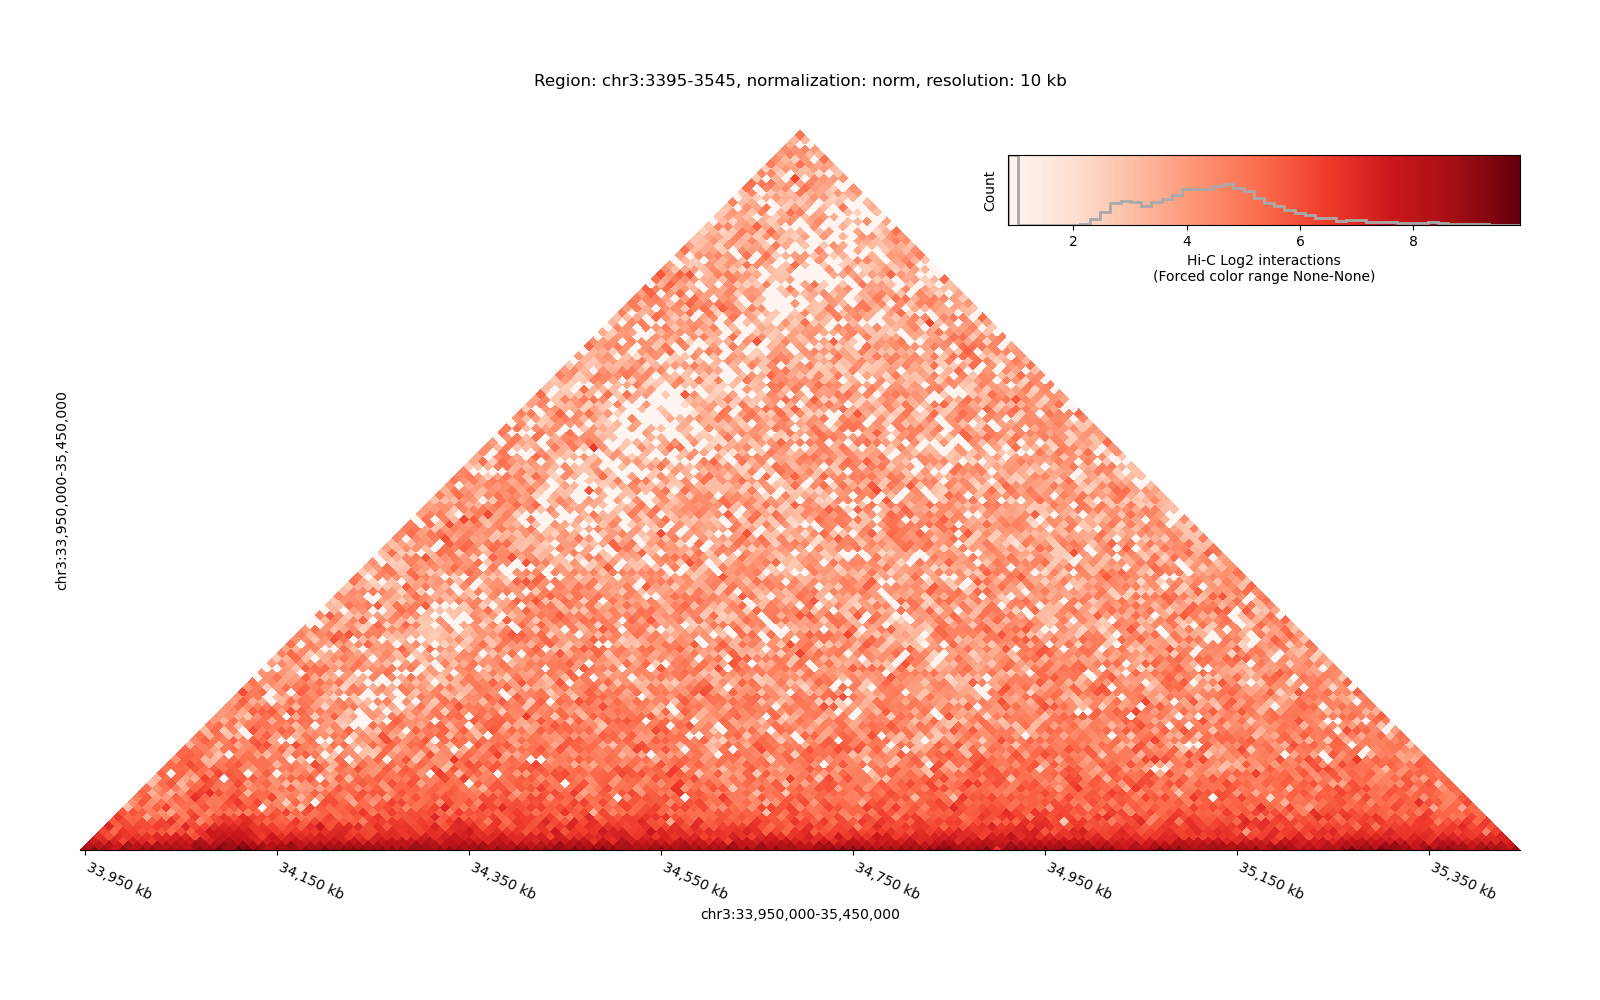

In [28]:
Image(filename='../results/B_rep1/05_sub-matrices/nrm_chr3:3395-3545_10kb_ef2379a427_tri.png') 

In [29]:
%%bash

tadbit bin -w ../results/B_rep1/ --only_txt \
    -c chr3:33950000-35450000 --resolution 10000  \
    --norm norm \
    --jobid 17


Extraction of chr3:33950000-35450000
Getting and writing matrices                                                   [2022-11-16 10:59:32]

  (Matrix size 150x150)                                                        [2022-11-16 10:59:32]

  - Parsing BAM (75 chunks)                                                    [2022-11-16 10:59:32]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

  - Writing matrices                                                           [2022-11-16 10:59:32]
     .......... .......... .......... .......... ..........      50/75
     .......... .......... .....                                 75/75

Cleaning                                                                       [2022-11-16 10:59:33]
Saving to DB                                                                   [2022-11-16 10:59:33]
,------.
| JOBs |
,----.--------------------------------------------

In [30]:
%%bash

tadbit model -w ../results/B_rep1/ \
    --reso 10000 \
    --crm chr3 \
    --beg 33950000 --end 35450000 \
    --maxdist 175 \
    --upfreq=-0.8:-0.2:0.2 \
    --lowfreq=-1.4:-1.0:0.2 \
    --dcutoff 2:4:1 \
    --scale 0.01 \
    --nmodels 200 --nkeep 100 \
    --cpu 16 \
    --jobid 19 \
    --optimize

     o Loading Hi-C matrix

        Optimization
        ***********

          - Region: Chromosome chr3 from 33950000 to 35450000 at resolution 10 kb (150 particles)

     o Optimizing parameters

Optimizing parameters...


#  Optimization UpFreq LowFreq MaxDist  scale  cutoff | Correlation

       1/3        -0.8    -1.4     175   0.01     2.0 | 0.6388
       2/3        -0.8    -1.4     175   0.01     3.0 | 0.1365
/home/dcastillo/miniconda2/envs/3DAROC22/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
       3/3        -0.8    -1.4     175   0.01     4.0 | nan
       1/3        -0.8    -1.2     175   0.01     2.0 | 0.6216
       2/3        -0.8    -1.2     175   0.01     3.0 | 0.1478
       3/3        -0.8    -1.2     175   0.01     4.0 | nan
       1/3        -0.8      -1     175   0.01     2.0 | 0.6222
       2/3        -0.8

In [31]:
from IPython.display import IFrame

IFrame("../results/B_rep1/07_model/032bcd0451_chr3_3396-3545/optimal_params_JPWuQaRFkM.pdf", width=600, height=300)
